In [4]:
import wfdb 
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.signal as signal
import scipy.stats as stats
import seaborn as sns
from collections import Counter
import librosa
import librosa.display

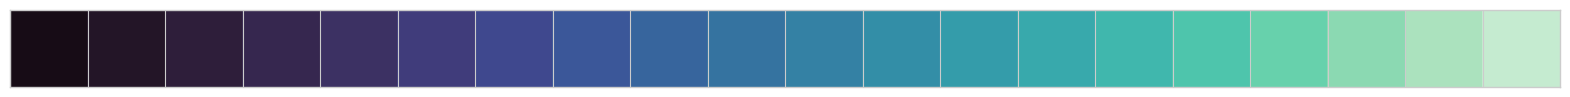

In [5]:
color_palette = sns.color_palette("mako", 20)
# plot settings
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set_palette(color_palette)
# plot colours
sns.palplot(color_palette)

In [6]:
data_loc = "data/apnea_ecg/"

def get_patient(patient):
    record = wfdb.rdrecord(data_loc + patient)
    annotation = wfdb.rdann(data_loc + patient, 'apn')
    return record, annotation

In [7]:
a01r, a01ann = get_patient("a01r")

In [8]:
a01ann.__dict__

{'record_name': 'a01r',
 'extension': 'apn',
 'sample': array([      0,    6000,   12000,   18000,   24000,   30000,   36000,
          42000,   48000,   54000,   60000,   66000,   72000,   78000,
          84000,   90000,   96000,  102000,  108000,  114000,  120000,
         126000,  132000,  138000,  144000,  150000,  156000,  162000,
         168000,  174000,  180000,  186000,  192000,  198000,  204000,
         210000,  216000,  222000,  228000,  234000,  240000,  246000,
         252000,  258000,  264000,  270000,  276000,  282000,  288000,
         294000,  300000,  306000,  312000,  318000,  324000,  330000,
         336000,  342000,  348000,  354000,  360000,  366000,  372000,
         378000,  384000,  390000,  396000,  402000,  408000,  414000,
         420000,  426000,  432000,  438000,  444000,  450000,  456000,
         462000,  468000,  474000,  480000,  486000,  492000,  498000,
         504000,  510000,  516000,  522000,  528000,  534000,  540000,
         546000,  5520

In [9]:
patients = ["a01r", "a02r", "a03r", "a04r", "b01r", "c01r", "c02r", "c03r"]

for patient in patients:
    record, annotation = get_patient(patient)
    print(f"patient {patient} has signal names {record.sig_name}")
    print(f"patient {patient} has {Counter(annotation.symbol)} annotations")

patient a01r has signal names ['Resp C', 'Resp A', 'Resp N', 'SpO2']
patient a01r has Counter({'A': 470, 'N': 19}) annotations
patient a02r has signal names ['Resp C', 'Resp A', 'Resp N', 'SpO2']
patient a02r has Counter({'A': 420, 'N': 108}) annotations
patient a03r has signal names ['Resp C', 'Resp A', 'Resp N', 'SpO2']
patient a03r has Counter({'N': 273, 'A': 246}) annotations
patient a04r has signal names ['Resp C', 'Resp A', 'Resp N', 'SpO2']
patient a04r has Counter({'A': 453, 'N': 39}) annotations
patient b01r has signal names ['Resp C', 'Resp A', 'Resp N', 'SpO2']
patient b01r has Counter({'N': 468, 'A': 19}) annotations
patient c01r has signal names ['Resp C', 'Resp A', 'Resp N', 'SpO2']
patient c01r has Counter({'N': 484}) annotations
patient c02r has signal names ['Resp C', 'Resp A', 'Resp N', 'SpO2']
patient c02r has Counter({'N': 501, 'A': 1}) annotations
patient c03r has signal names ['Resp C', 'Resp A', 'Resp N', 'SpO2']
patient c03r has Counter({'N': 454}) annotations


['Resp C', 'Resp A', 'Resp N', 'SpO2']


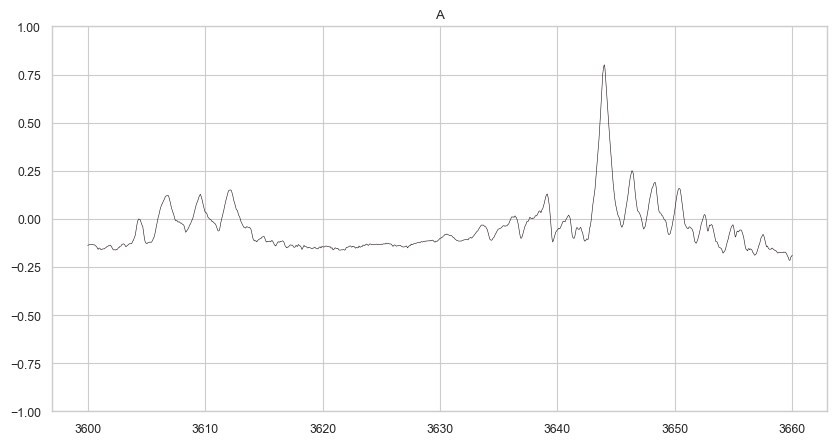

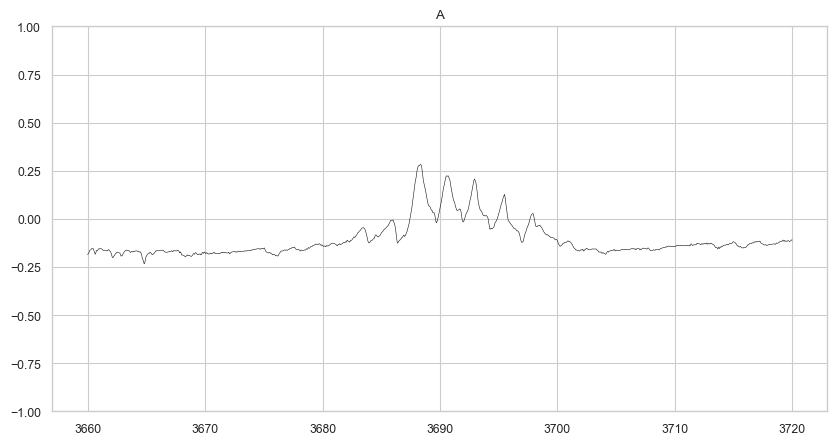

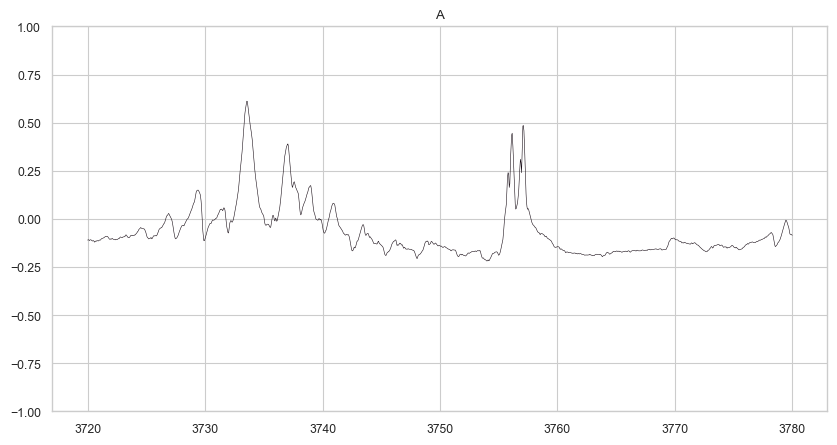

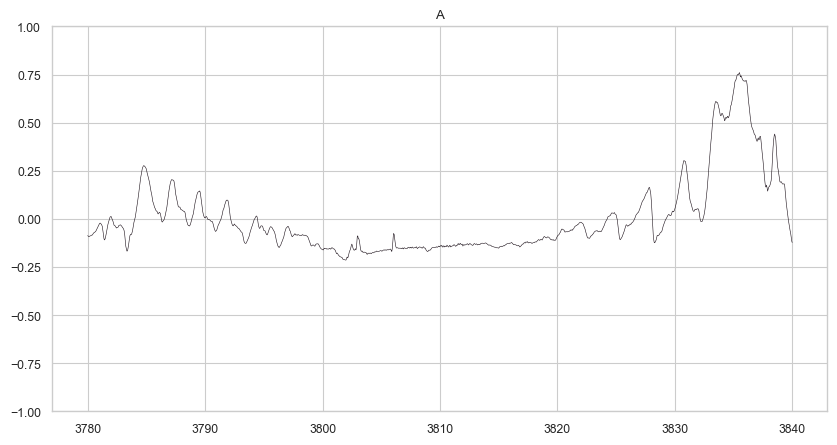

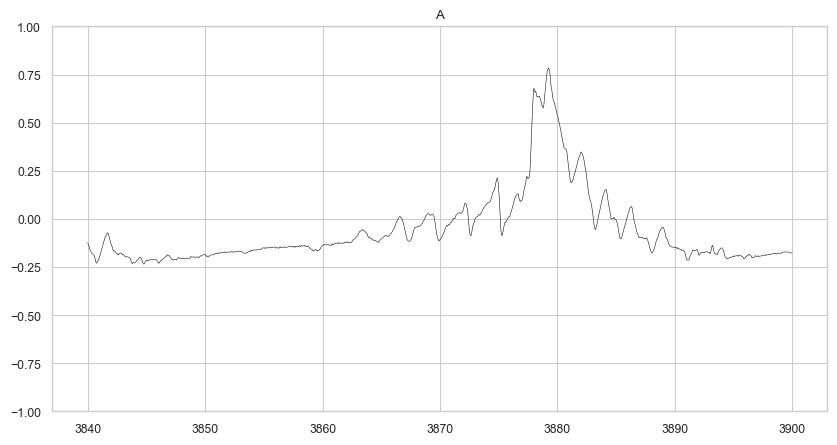

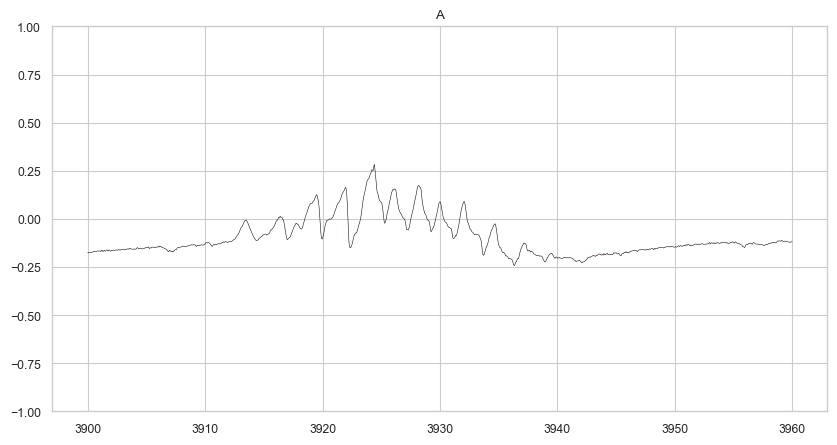

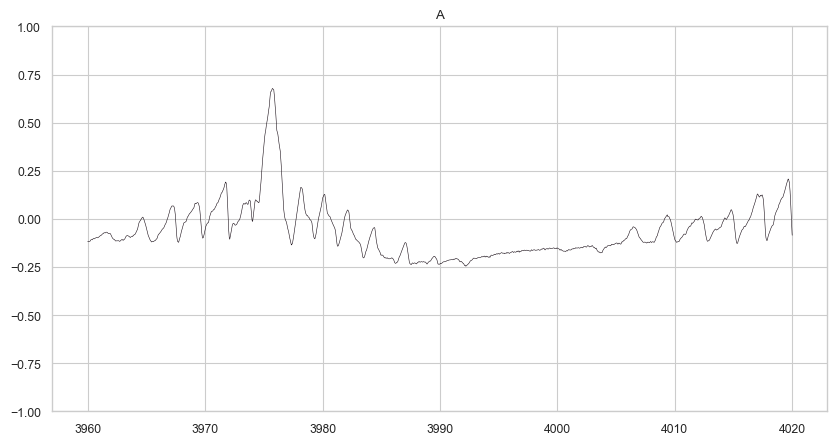

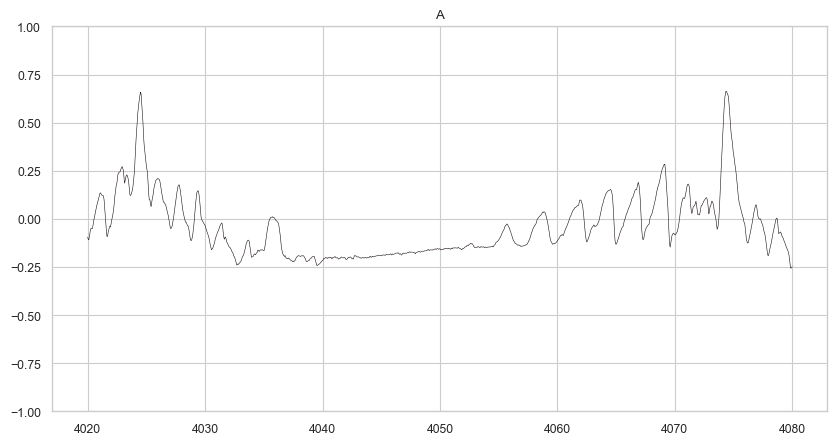

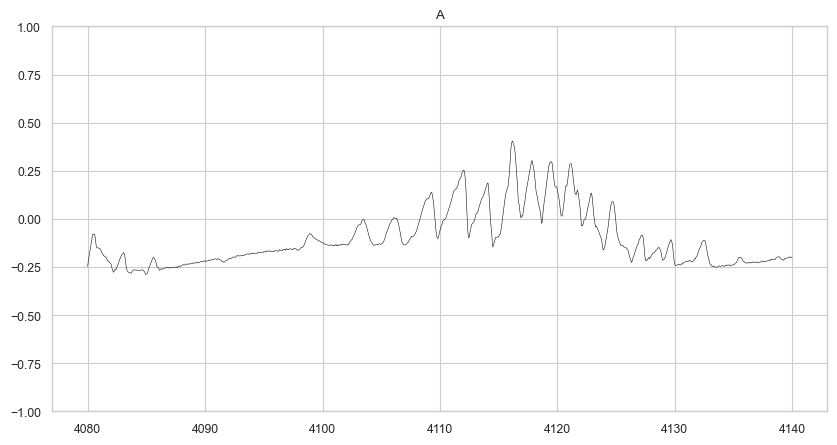

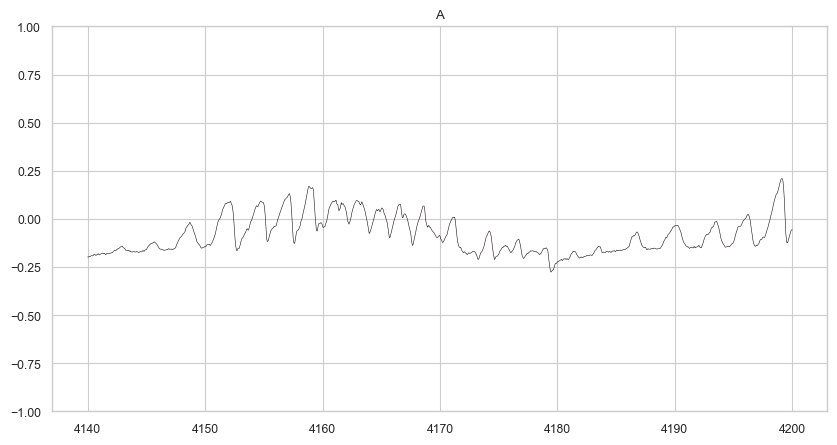

In [10]:

# create a function that takes a patient and returns the signal and the annotation


# create a function that takes signal and annotation of patient and plots 10 intervals of the signal from specified index in annotation.sample, title of plot should be the annotation.symbol
def plot_intervals(patient, start_index, num_intervals=10, save=False):
    record, annotation = get_patient(patient)
    print(f"{record.sig_name}")
    for i in range(start_index, start_index + num_intervals):
        start = annotation.sample[i]
        end = annotation.sample[i+1]
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(start, end)/record.fs ,record.p_signal[start:end, 0], lw=0.4)
        plt.title(annotation.symbol[i])
        plt.ylim(-1, 1)
        if save:
            if not os.path.exists(f"plots/{patient}/"):
                os.makedirs(f"plots/{patient}/")
            plt.savefig(f"plots/{patient}/{patient}_index_sample_{annotation.sample[i]}_label_{annotation.symbol[i]}.png")
        plt.show()

# plot 10 intervals of patient a01r starting from index 0
# 'b01r', 'c01r', 'c02r', 'c03r'
plot_intervals("a02r", 60, save=False)


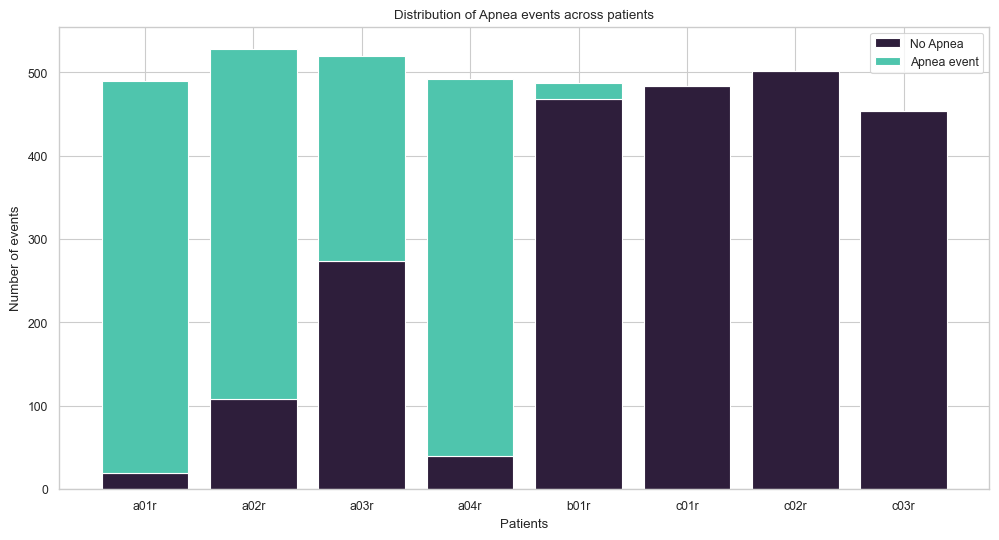

In [11]:
import seaborn as sns

# for each patient, get the distribution of the labels
def get_distribution(patients):
    distributions = []
    for patient in patients:
        record, annotation = get_patient(patient)
        distributions.append(Counter(annotation.symbol))
    return distributions

distributions = get_distribution(patients)

# plot the distribution of the labels for each patient
def plot_distribution(distributions):
    for i, distribution in enumerate(distributions):
        plt.figure(figsize=(10, 5))
        plt.bar(distribution.keys(), distribution.values())
        plt.title(f"Patient {patients[i]}")
        plt.show()

# get the distributions of the 2 labels across all patients
def get_label_distribution(distributions):
    label_distributions = []
    for distribution in distributions:
        label_distributions.append([distribution["N"], distribution["A"]])
    return label_distributions

label_distributions = get_label_distribution(distributions)

# plot the distribution of the labels across all patients

def plot_label_distribution(label_distributions):

    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(len(label_distributions)), [x[0] for x in label_distributions], label="No Apnea", color=color_palette[2])
    plt.bar(np.arange(len(label_distributions)), [x[1] for x in label_distributions], bottom=[x[0] for x in label_distributions], label="Apnea event", color=color_palette[15])
    plt.xticks(np.arange(len(label_distributions)), patients)
    plt.title("Distribution of Apnea events across patients")
    plt.xlabel("Patients")
    plt.ylabel("Number of events")
    plt.legend()
    plt.show()

plot_label_distribution(label_distributions)


In [12]:
def segment_signal(record, annotation):
    segments = []
    labels = []
    for i in range(len(annotation.symbol)-1):
        start = annotation.sample[i]
        if i != len(annotation.symbol) - 1:
            end = annotation.sample[i+1]
        else:
            end = annotation.sample[i] + 6000
        segments.append(record.p_signal[start:end, 0])
        labels.append(annotation.symbol[i])
    return segments, labels

In [13]:
# function to check if segment is valid and doesn't contain NaN values
def is_valid_segment(segment):
    return not np.isnan(segment).any()

# get invalid segments
def get_invalid_segments(segments):
    invalid_segments = []
    for i, segment in enumerate(segments):
        if not is_valid_segment(segment):
            invalid_segments.append(i)
            # get the index of the nan values in the segment
            # nan_indices = np.argwhere(np.isnan(segment))
            # print the nan indices of the segment
            # print(f"segment {i} has nan values at indices {nan_indices}")

    return invalid_segments


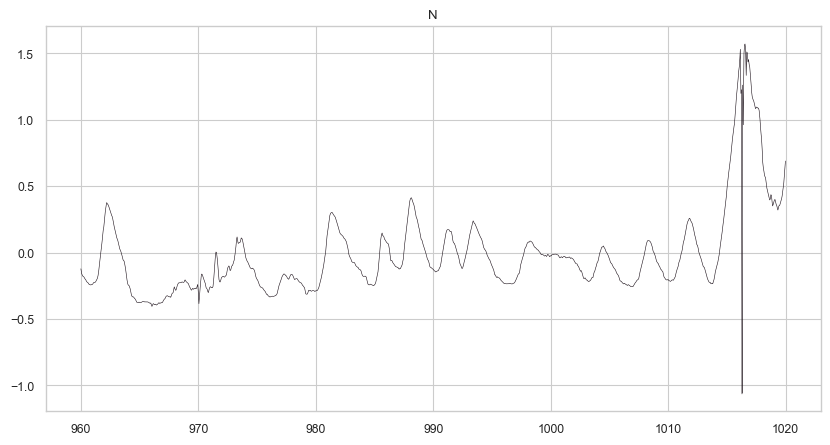

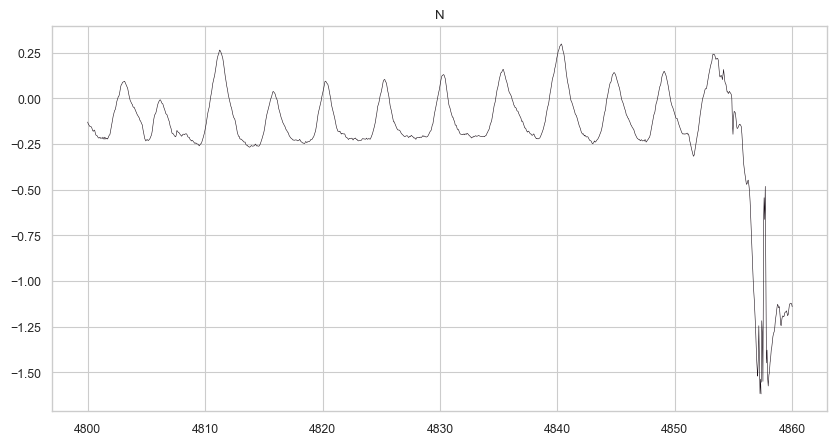

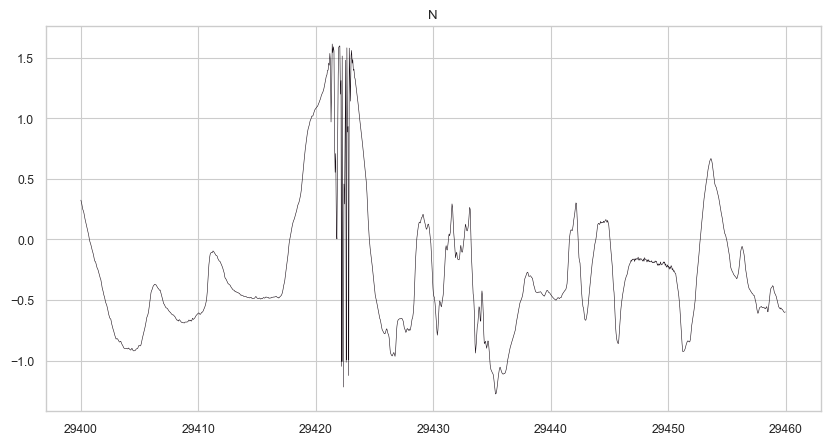

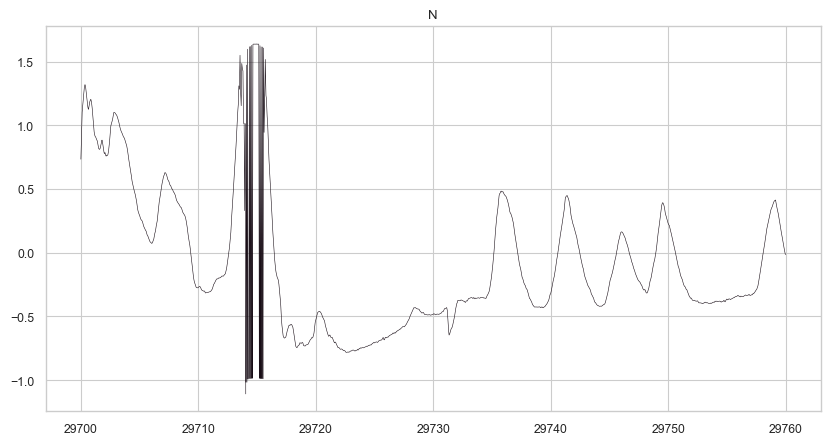

In [14]:
# plot the invalid segments
curr = patients[6]
record, annotation = get_patient(curr)
segments, labels = segment_signal(record, annotation)
def plot_invalid_segments(patient, invalid_segments):
    record, annotation = get_patient(patient)
    for i in invalid_segments:
        start = annotation.sample[i]
        if i != len(annotation.symbol) - 1:
            end = annotation.sample[i+1]
        else:
            end = annotation.sample[i] + 6000
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(start, end)/record.fs ,record.p_signal[start:end, 0], lw=0.4)
        plt.title(annotation.symbol[i])
        plt.show()

# get the invalid segments for patient a01r
invalid_segments = get_invalid_segments(segments)
plot_invalid_segments(curr, invalid_segments)

In [15]:
# get the valid segments of the patient
def get_valid_segments(record, annotation):
    segments, labels = segment_signal(record, annotation)
    invalid_segments = get_invalid_segments(segments)
    valid_segments = []

    valid_labels = []
    for i in range(len(segments)):
        if i not in invalid_segments:
            valid_segments.append(segments[i])
            valid_labels.append(labels[i])
    # make sure the valid segments don't contain any nan values
    assert not get_invalid_segments(valid_segments)

    # check if the valid segments and labels are the same length
    assert len(valid_segments) == len(valid_labels)
    return valid_segments, valid_labels

def plot_stft(segments, labels, n_fft, hop_length, num_segments=10):
    for i in range(num_segments):
        plt.figure(figsize=(10, 5))
        plt.title(labels[i])
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        librosa.display.specshow(get_stft(segments[i], n_fft=n_fft, hop_length=hop_length), cmap='plasma', y_axis='log', x_axis='time')
        plt.colorbar()
        plt.show()


In [16]:
# get the segments and labels for each patient
curr = patients[7]
record, annotation = get_patient(curr)
segments, labels = get_valid_segments(record, annotation)

print(f"patient {curr} has {len(segments)} valid segments")
print(f"patient {curr} has {len(labels)} valid labels")
print(f"patient {curr} has {Counter(labels)} valid labels")
n_fft = 512
hop_length = 32
# plot_stft(segments, labels, n_fft, hop_length, num_segments=10)

patient c03r has 446 valid segments
patient c03r has 446 valid labels
patient c03r has Counter({'N': 446}) valid labels


In [20]:

# function to one hot encode the labels
def one_hot_labels(y):
    y_onehot = []
    y_unique = sorted(set(y))
    for label in y:
        onehot = [0] * len(y_unique)
        onehot[y_unique.index(label)] = 1
        y_onehot.append(onehot)
    return np.array(y_onehot)

def get_stft_features(X, n_fft, hop_length, center=True):
    stft_feature = []

    count = 0
    for signal in X:
        stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, center=center)
        stft = librosa.amplitude_to_db(stft)
        stft = stft.T 
        stft_feature.append(stft)
        count += 1
        if count % 100 == 0:
            print(f"Processed {count} signals")
    return np.array(stft_feature, dtype=np.float32)

In [21]:
# for each patient, get stft of the valid segments, and store them as a png file

def get_valid_segments_all(patients):
    
    valid_segs = []
    valid_labels = []
    for patient in patients:
        record, annotation = get_patient(patient)
        curr_valid_segments, curr_valid_labels = get_valid_segments(record, annotation)
        valid_segs.extend(curr_valid_segments)
        valid_labels.extend(curr_valid_labels)
    return valid_segs, valid_labels

def save_stft_as_png(patients, n_fft, hop_length, save_path= "test_stft/"):
    
    segments, labels = get_valid_segments_all(patients)
    
    # check length of segments and labels
    
    assert len(segments) == len(labels)
    
    ohe_labels = one_hot_labels(labels)

    stft_feats = get_stft_features(segments, n_fft, hop_length)

    # save the stft features and labels as npy files
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    np.save(save_path + "stft_features.npy", stft_feats)
    np.save(save_path + "labels.npy", ohe_labels)

    # print the shape of the stft features and labels
    print(f"stft features shape: {stft_feats.shape}")
    print(f"labels shape: {ohe_labels.shape}")

save_stft_as_png(patients, n_fft, hop_length, save_path="stft/")

C:\Users\hamad\AppData\Local\Temp\ipykernel_26516\1395588507.py:17: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  stft = librosa.amplitude_to_db(stft)


Processed 100 signals
Processed 200 signals
Processed 300 signals
Processed 400 signals
Processed 500 signals
Processed 600 signals
Processed 700 signals
Processed 800 signals
Processed 900 signals
Processed 1000 signals
Processed 1100 signals
Processed 1200 signals
Processed 1300 signals
Processed 1400 signals
Processed 1500 signals
Processed 1600 signals
Processed 1700 signals
Processed 1800 signals
Processed 1900 signals
Processed 2000 signals
Processed 2100 signals
Processed 2200 signals
Processed 2300 signals
Processed 2400 signals
Processed 2500 signals
Processed 2600 signals
Processed 2700 signals
Processed 2800 signals
Processed 2900 signals
Processed 3000 signals
Processed 3100 signals
Processed 3200 signals
Processed 3300 signals
Processed 3400 signals
Processed 3500 signals
Processed 3600 signals
Processed 3700 signals
Processed 3800 signals
stft features shape: (3855, 188, 257)
labels shape: (3855, 2)


In [ ]:


# Define the window size and overlap
window_size = 4 * record.fs
overlap = 2 * record.fs
starting = 0



In [94]:
import os
import numpy as np
import wfdb
from scipy import signal
import librosa
import matplotlib.pyplot as plt

def create_spectrograms():
    # Create the "data/processed" directory if it doesn't exist
    processed_dir = "data/processed"
    if not os.path.exists(processed_dir):
        os.makedirs(processed_dir)

    # Define the patients to load data from
    patients = ['a01r', 'a02r', 'a03r', 'a04r', 'b01r', 'c01r', 'c02r', 'c03r']

    # Create a dictionary to store the spectrograms
    spectrograms = {'STFT': {}, 'Mel': {}, 'LogMel': {}}

    # Iterate over the patients
    for patient in patients:
        # Load the record and annotation
        record = wfdb.rdrecord(f"data/apnea_ecg/{patient}")
        annotation = wfdb.rdann(f"data/apnea_ecg/{patient}", 'apn')

        # Iterate over the 60-second intervals
        interval_length = 60 * record.fs
        for i in range(len(record.p_signal) // interval_length):
            # Extract the interval signal
            start_index = i * interval_length
            end_index = (i + 1) * interval_length
            interval_signal = record.p_signal[start_index:end_index, 0]

            # Handle NaN values and Normalize the interval signal
            interval_signal = np.nan_to_num(interval_signal)
            interval_signal = (interval_signal - np.mean(interval_signal)) / np.std(interval_signal)

            # Compute the STFT spectrogram
            _, _, Zxx = signal.stft(interval_signal, fs=record.fs)
            stft_spec = np.abs(Zxx)

            # Convert STFT to Mel spectrogram
            mel_spec = librosa.feature.melspectrogram(S=stft_spec, sr=record.fs)

            # Convert Mel spectrogram to LogMel spectrogram
            logmel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            # Label for the current interval
            label = annotation.symbol[i] if i < len(annotation.symbol) else "Unknown"

            # Store the spectrograms
            for spec_type, spec_data in zip(['STFT', 'Mel', 'LogMel'], [stft_spec, mel_spec, logmel_spec]):
                if label not in spectrograms[spec_type]:
                    spectrograms[spec_type][label] = []
                spectrograms[spec_type][label].append(spec_data)

    # Save the spectrograms as image files
    for spec_type, labels in spectrograms.items():
        for label, spectrogram_list in labels.items():
            for i, spectrogram in enumerate(spectrogram_list):
                filename = f"{spec_type}_{label}_{i}.png"
                filepath = os.path.join(processed_dir, filename)
                plt.imsave(filepath, spectrogram)

    return "Spectrograms created and stored successfully."

# Call the function to create the spectrograms
create_spectrograms()


C:\Users\hamad\AppData\Local\Temp\ipykernel_40532\3073777779.py:36: RuntimeWarning: invalid value encountered in divide
  interval_signal = (interval_signal - np.mean(interval_signal)) / np.std(interval_signal)
C:\Users\hamad\AppData\Local\Temp\ipykernel_40532\3073777779.py:36: RuntimeWarning: invalid value encountered in divide
  interval_signal = (interval_signal - np.mean(interval_signal)) / np.std(interval_signal)


'Spectrograms created and stored successfully.'

In [95]:
import os
import shutil

def organize_spectrogram_images(source_dir, target_dir):
    """
    Organize spectrogram images into subfolders based on their type and label.
    
    Parameters:
    - source_dir: Directory containing the original spectrogram images.
    - target_dir: Directory where the organized images will be stored.
    """
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for filename in os.listdir(source_dir):
        if filename.endswith('.png'):
            # Extract spectrogram type and label from the filename
            spec_type, label, _ = filename.split('_')

            # Create a subdirectory for the spectrogram type if it doesn't exist
            spec_type_dir = os.path.join(target_dir, spec_type)
            if not os.path.exists(spec_type_dir):
                os.makedirs(spec_type_dir)

            # Create a subdirectory for the label within the spectrogram type directory
            label_dir = os.path.join(spec_type_dir, label)
            if not os.path.exists(label_dir):
                os.makedirs(label_dir)

            # Move the file to the appropriate subdirectory
            src_file = os.path.join(source_dir, filename)
            dest_file = os.path.join(label_dir, filename)
            shutil.move(src_file, dest_file)

    print("Spectrogram images organized successfully.")

# Example usage
source_directory = "data/processed"
target_directory = "data/organized_spectrograms"
organize_spectrogram_images(source_directory, target_directory)


Spectrogram images organized successfully.
